## Additive attention
Paper: [Neural machine translation by jointly learning to align and translate](https://arxiv.org/pdf/1409.0473) - Bahdanau et. al 2015

Dataset: [Multi30K English to Deutsche dataset](https://huggingface.co/datasets/bentrevett/multi30k)

Model: Use LSTM as encoder and decoder

#### Model variations
- Stacked LSTM encoder decoder
- BiLSTM encoder + LSTM decoder



In [ ]:
# colab specifics
%pip install early-stopping-pytorch

In [140]:
import random
import numpy as np
import torch

SEED = 1557
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [141]:
from datasets import load_dataset

train_dataset = load_dataset("bentrevett/multi30k", split="train")
print(len(train_dataset))
print(train_dataset[0])

29000
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [142]:
import re

TOKEN_RE = re.compile(r"\w+|[^\w\s]")
def word_tokenize(text):
    text = text.lower().strip()
    return TOKEN_RE.findall(text)

In [5]:
word_tokenize("Hello, world!")

['hello', ',', 'world', '!']

In [143]:
from collections import Counter

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

SPECIAL_TOKENS = [PAD, BOS, EOS, UNK]

def build_vocab(tokenized_texts, max_vocab_size=10000, min_freq=3):
    counter = Counter(token for text in tokenized_texts for token in text)
    vocab = SPECIAL_TOKENS.copy()

    for token, freq in counter.most_common():
        if freq < min_freq:
            break
        if len(vocab) >= max_vocab_size:
            break
        if token not in vocab:
            vocab.append(token)

    vocab_to_index = {token: index for index, token in enumerate(vocab)}
    index_to_vocab = {index: token for token, index in vocab_to_index.items()}

    return vocab_to_index, index_to_vocab

In [144]:
def add_special_tokens(tokens):
    return [BOS] + tokens + [EOS]

def remove_special_tokens(tokens):
    return [token for token in tokens if token not in [PAD, BOS, EOS]]

def encode(token_to_index, text):
    return [token_to_index.get(token, token_to_index[UNK]) for token in text]

def decode(index_to_token, indices):
    return " ".join(remove_special_tokens([index_to_token.get(index, UNK) for index in indices]))


In [145]:
# Load data and build vocab

tokenized_train_dataset = train_dataset.map(lambda x: {"en": word_tokenize(x["en"]), "de": word_tokenize(x["de"])}, batched=False)

en_vocab_to_index, en_index_to_vocab = build_vocab(
    [item["en"] for item in tokenized_train_dataset]
)
de_vocab_to_index, de_index_to_vocab = build_vocab(
    [item["de"] for item in tokenized_train_dataset]
)

In [9]:
print(f"English Vocab size: {len(en_vocab_to_index)}")
print(f"German Vocab size: {len(de_vocab_to_index)}")
print(tokenized_train_dataset[0])

English Vocab size: 4560
German Vocab size: 5422
{'en': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'de': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']}


In [146]:
def preprocess(batch, source_lang, target_lang, source_vocab_to_index, target_vocab_to_index):
    source_encodings = [encode(source_vocab_to_index, add_special_tokens(word_tokenize(text))) for text in batch[source_lang]]
    target_encodings = [encode(target_vocab_to_index, add_special_tokens(word_tokenize(text))) for text in batch[target_lang]]

    return {"source": source_encodings, "target": target_encodings}


In [147]:
preprocessed_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
preprocessed_train_dataset.set_format(type="torch", columns=["source", "target"])

print(preprocessed_train_dataset[0])
print(f"German: {decode(de_index_to_vocab, preprocessed_train_dataset[0]['source'].tolist())}")
print(f"English: {decode(en_index_to_vocab, preprocessed_train_dataset[0]['target'].tolist())}")

{'source': tensor([   1,   18,   27,  215,   31,   85,   20,   89,    7,   15,  115,    3,
        3149,    4,    2]), 'target': tensor([   1,   16,   24,   15,   25,  776,   17,   57,   80,  204, 1305,    5,
           2])}
German: zwei junge weiße männer sind im freien in der nähe <unk> büsche .
English: two young , white males are outside near many bushes .


In [148]:
import torch

def pad_batch(sequences, pad_idx=0):
    dtype = sequences[0].dtype

    lengths = torch.tensor([len(seq) for seq in sequences])
    max_length = int(lengths.max().item())

    padded_batch = torch.full((len(sequences), max_length), pad_idx, dtype=dtype)
    for i, seq in enumerate(sequences):
        end = lengths[i]
        padded_batch[i, :end] = seq
    return padded_batch, lengths

def collate_fn(batch):
    source = [item["source"] for item in batch]
    target = [item["target"] for item in batch]

    source, source_lengths = pad_batch(source) # defer padding till batching
    target, target_lengths = pad_batch(target)

    return {"source": source, "source_lengths": source_lengths, "target": target, "target_lengths": target_lengths}

In [149]:
from torch.utils.data import DataLoader
loader = DataLoader(
    preprocessed_train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn,
)

batch = next(iter(loader))
print(batch["source"].shape)
print(batch["source_lengths"].shape)
print(batch["target"].shape)
print(batch["target_lengths"].shape)

torch.Size([3, 15])
torch.Size([3])
torch.Size([3, 16])
torch.Size([3])


In [150]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, device, padding_idx=0):
        super().__init__()
        self.directions = 2
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.hidden_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.cell_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.device = device

    def forward(self, source_encodings, source_lengths): # source_encodings: (batch_size, max_length), source_lengths: (batch_size)
        B, T = source_encodings.size()
        h_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)
        c_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)

        embedded = self.embedding(source_encodings) # (B, T, embedding_dim)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_outputs, (last_hidden, last_cell) = self.lstm(packed_embedded, (h_0, c_0)) # hidden: (num_layers * directions, B, hidden_dim)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True) # outputs: (B, T, hidden_dim * directions)

        h_f = last_hidden[0::2] # (num_layers, B, hidden_dim)
        h_b = last_hidden[1::2] # (num_layers, B, hidden_dim)
        h_cat = torch.cat((h_f, h_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        c_f = last_cell[0::2] # (num_layers, B, hidden_dim)
        c_b = last_cell[1::2] # (num_layers, B, hidden_dim)
        c_cat = torch.cat((c_f, c_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        last_hidden = torch.tanh(self.hidden_projection(h_cat)) # (num_layers, B, hidden_dim)
        last_cell = torch.tanh(self.cell_projection(c_cat)) # (num_layers, B, hidden_dim)

        return outputs, last_hidden, last_cell


In [15]:
encoder = Encoder(len(de_vocab_to_index), 120, 256, 2, 0.0, 'cpu')

outputs, last_hidden, last_cell = encoder(batch["source"], batch["source_lengths"])

print(f"outputs (B, T, hidden_dim * directions): {outputs.shape}")
print(f"last_hidden (num_layers * directions, B, hidden_dim): {last_hidden.shape}")
print(f"last_cell (num_layers * directions, B, hidden_dim): {last_cell.shape}")

print(f"last_hidden: {last_hidden}")


outputs (B, T, hidden_dim * directions): torch.Size([3, 15, 512])
last_hidden (num_layers * directions, B, hidden_dim): torch.Size([2, 3, 256])
last_cell (num_layers * directions, B, hidden_dim): torch.Size([2, 3, 256])
last_hidden: tensor([[[ 2.7087e-02, -6.1209e-02, -1.4815e-02,  ...,  1.9722e-02,
          -3.7388e-02, -2.1360e-02],
         [ 2.5211e-02, -3.1794e-02, -1.1095e-02,  ...,  1.7036e-02,
          -1.7297e-02, -5.8430e-03],
         [ 5.5512e-02, -5.2913e-02, -5.8107e-03,  ...,  2.6833e-02,
          -1.9347e-02, -4.1027e-02]],

        [[-6.8816e-03, -3.6020e-02, -8.7713e-03,  ..., -2.6719e-02,
           2.2928e-02,  5.5497e-03],
         [-9.2412e-04, -3.9845e-02, -8.9638e-05,  ..., -2.4526e-02,
           2.3791e-02,  7.2831e-03],
         [-2.3866e-03, -3.6656e-02, -5.3476e-03,  ..., -3.2279e-02,
           2.7942e-02,  1.0705e-02]]], grad_fn=<TanhBackward0>)


In [151]:
class Decoder(nn.Module):
    """
    Decoder for the Seq2Seq model. This works on a batch of single step targets (B, 1).
    It doesn't take the entire target sequence, because the decision to teacher force and what kind of search strategy to use
    is done at the sequence level, not the step level.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, padding_idx=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False,
        )
        self.encoder_hidden_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.encoder_cell_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, target, encoder_last_hidden, encoder_last_cell):
        # Normalize target shape to (B, 1)
        if target.dim() == 0:
            target = target.view(1, 1)
        else:
            target = target.unsqueeze(1)

        target = target.long()

        embedded = self.embedding(target)  # (B, T, embedding_dim)
        # use dropout on the embedded input later
        outputs, (hidden, cell) = self.lstm(embedded, (encoder_last_hidden, encoder_last_cell)) # (B, 1, hidden_dim)
        logits = self.output_projection(outputs) # (B, 1, vocab_size)

        return logits, hidden, cell

In [17]:
decoder = Decoder(len(en_vocab_to_index), 120, 256, 2, 0.0)

# One decoding step for the whole batch (B,)
step0 = batch["target"][:, 0]
print(step0.shape, step0)

logits, hidden, cell = decoder(step0, last_hidden, last_cell)
print(f"logits (B, 1, vocab_size): {logits.shape}")
print(f"hidden (num_layers, B, hidden_dim): {hidden.shape}")
print(f"cell (num_layers, B, hidden_dim): {cell.shape}")
print(logits)


torch.Size([3]) tensor([1, 1, 1])
logits (B, 1, vocab_size): torch.Size([3, 1, 4560])
hidden (num_layers, B, hidden_dim): torch.Size([2, 3, 256])
cell (num_layers, B, hidden_dim): torch.Size([2, 3, 256])
tensor([[[-0.0045, -0.0050, -0.0049,  ...,  0.0866, -0.0391,  0.0025]],

        [[-0.0106, -0.0081, -0.0085,  ...,  0.0898, -0.0361,  0.0049]],

        [[-0.0015, -0.0042, -0.0023,  ...,  0.0865, -0.0424,  0.0055]]],
       grad_fn=<ViewBackward0>)


In [152]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, bos_idx, eos_idx, max_target_length, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_target_length = max_target_length
        self.device = device

    def forward(self, source, source_lengths, target=None):
        B = source.shape[0]


        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        if target is not None:
            steps = target.shape[1] - 1
            inputs = target[:, 0]
        else:
            steps = self.max_target_length
            inputs = torch.full((B,), self.bos_idx, dtype=torch.long)

        logits_all = torch.zeros(B, steps, self.decoder.vocab_size, device=self.device)
        preds_all = torch.zeros(B, steps, device=self.device)

        for t in range(steps):
            logits, hidden, cell = self.decoder(inputs, hidden, cell)
            step_logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)
            step_preds = step_logits.argmax(dim=1)

            logits_all[:, t, :] = step_logits
            preds_all[:, t] = step_preds

            # Teacher forcing
            if target is not None:
                inputs = target[:, t + 1]
            else:
                inputs = step_preds
                if step_preds.eq(self.eos_idx).all():
                    break

        return logits_all, preds_all


In [153]:
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab_to_index[PAD])

In [20]:
model = Seq2Seq(encoder, decoder, de_vocab_to_index[BOS], de_vocab_to_index[EOS], 30, 'cpu')

logits_all, preds_all = model(batch["source"], batch["source_lengths"], batch["target"])
target = batch["target"][:, 1:].reshape(-1)
loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)


print(f"logits_all.shape: {logits_all.shape}")
print(f"preds_all.shape: {preds_all.shape}")
print(f"batch['target'].shape: {batch['target'].shape}")
print(f"loss: {loss}\n")

for i in range(len(batch.items())-1):
    print(f"Source: {decode(de_index_to_vocab, batch['source'][i].tolist())}")
    print(f"Target: {decode(en_index_to_vocab, batch['target'][i].tolist())}")
    print(f"Pred: {decode(en_index_to_vocab, preds_all[i].tolist())}")
    print("-"*100)

logits_all.shape: torch.Size([3, 15, 4560])
preds_all.shape: torch.Size([3, 15])
batch['target'].shape: torch.Size([3, 16])
loss: 8.412188529968262

Source: ein junger mann in „ <unk> “ - hemd an einer <unk> .
Target: a young man in a " <unk> " shirt at a reception desk .
Pred: more women dot dot dot dot dot dot dot give computers camcorder wear wear wear
----------------------------------------------------------------------------------------------------
Source: feuerwehrleute löschen ein feuer .
Target: firemen are putting our a fire .
Pred: more nails more dot maneuver boxing boxing boxing waterskier waterskier dot dot dot dot dot
----------------------------------------------------------------------------------------------------
Source: ein grün gekleideter mann springt mit seinem skateboard auf der straße .
Target: a man wearing green jumps with his skateboard in the street .
Pred: more women freeway operating concert vests maneuver sale maneuver operating descending flooded crysta

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [155]:
tgt_vocab_size = len(en_vocab_to_index) # 4560
src_vocab_size = len(de_vocab_to_index) # 5422
emb_dim = 512
hidden_dim = 512
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.0
dec_dropout = 0.0
padding_idx = de_vocab_to_index[PAD]
bos_idx = de_vocab_to_index[BOS]
eos_idx = de_vocab_to_index[EOS]
max_target_length = 30

batch_size = 64
learning_rate = 0.0005
epochs = 15

In [156]:
basic_encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
basic_decoder = Decoder(tgt_vocab_size, emb_dim, hidden_dim, dec_num_layers, dec_dropout, padding_idx)

basic_model = Seq2Seq(basic_encoder, basic_decoder, bos_idx, eos_idx, max_target_length, device)
basic_model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
    (encoder_hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (encoder_cell_projection): Linear(in_features=1024, out_features=512, bias=True)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

### Model parameter calculation

#### Encoder
- source embedding: vocab * emb_dim + bias
- 2 layers BiLSTM:  
    - direction * gates * ( W_x + W_h + b_x + b_h)
    - direction * gates * ( W_h + W_h + b_h + b_h)
- hidden projection: 2 * (2 * hidden_dim * hidden_dim + b_h)

#### Decoder
- target embedding: vocab * emb_dim + bias
- 2 layers LSTM:
    - gates * ( W_x + W_h + b_x + b_h)
    - gates * ( W_x + W_h + b_x + b_h)
- output projection: hidden_dim * target_vocab + b_v

In [24]:
p_src_emd = src_vocab_size * emb_dim + src_vocab_size
p_enc_lstm_1 = 2 * 4 * (emb_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_enc_lstm_2 = 2 * 4 * (hidden_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_enc_hidden_proj = 2 * (2 * hidden_dim * hidden_dim + hidden_dim)
p_enc_cell_proj = 2 * (2 * hidden_dim * hidden_dim + hidden_dim)

p_encoder = p_src_emd + p_enc_lstm_1 + p_enc_lstm_2 + p_enc_hidden_proj + p_enc_cell_proj

print(f"Encoder parameters: {p_encoder:,}")

p_tgt_emd = tgt_vocab_size * emb_dim + tgt_vocab_size
p_dec_lstm_1 = 4 * (emb_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_dec_lstm_2 = 4 * (hidden_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_dec_output_proj = hidden_dim * tgt_vocab_size + tgt_vocab_size

p_decoder = p_tgt_emd + p_dec_lstm_1 + p_dec_lstm_2 + p_dec_output_proj

print(f"Decoder parameters: {p_decoder:,}")

p_seq2seq = p_encoder + p_decoder

print(f"Seq2Seq parameters: {p_seq2seq:,}")



Encoder parameters: 13,334,830
Decoder parameters: 8,905,632
Seq2Seq parameters: 22,240,462


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Seq2Seq model has {count_parameters(basic_model):,} trainable parameters')
print(f"Encoder parameters: {count_parameters(basic_encoder):,}")
print(f"Decoder parameters: {count_parameters(decoder):,}")


The Seq2Seq model has 24,253,904 trainable parameters
Encoder parameters: 14,327,808
Decoder parameters: 2,895,184


### Rough estimate of memory needed
- long or float32 = 4 bytes
- memory for model for Adam optimizer = 4 * mode parameters * 4 bytes
- activations of LSTM = 6 * hidden_dim * num_layers * batch_size * seq_len * 4 bytes
- activations embedding = batch_size * seq_len * embed_dim * 2
- hidden projection activations = batch_size * seq_len * hidden_dim * 2
- output project activation = batch_size * seq_len * tgt_vocab

total = sum of above + 30%

In [26]:
model_memory = 4 * 4 * p_seq2seq
activations_memory = 6 * hidden_dim * (enc_num_layers + dec_num_layers) * batch_size * max_target_length * 4
embedding_memory = batch_size * max_target_length * emb_dim * 2
hidden_projection_memory = batch_size * max_target_length * hidden_dim * 2
output_projection_memory = batch_size * max_target_length * tgt_vocab_size

total_activations_memory = activations_memory + embedding_memory + hidden_projection_memory + output_projection_memory
total_memory = model_memory + total_activations_memory


print(f"Total memory: {total_memory:,} bytes")
print(f"Model memory: {model_memory:,} bytes")
print(f"Activations memory: {activations_memory + embedding_memory + hidden_projection_memory + output_projection_memory:,} bytes")
print(f"Total required memory: {total_memory * 1.3:,} bytes")

Total memory: 462,906,592 bytes
Model memory: 355,847,392 bytes
Activations memory: 107,059,200 bytes
Total required memory: 601,778,569.6 bytes


In [157]:
optimizer = torch.optim.Adam(basic_model.parameters(), lr=learning_rate)

In [158]:
def batch_to_device(batch, device):
    return {k: v.to(device, non_blocking=True) if isinstance(v, torch.Tensor) else v
     for k, v in batch.items()}

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time % 60)
    return minutes, seconds

In [159]:
def train(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    for batch in loader:
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()

        logits_all, preds_all = model(batch["source"], batch["source_lengths"], batch["target"])
        target = batch["target"][:, 1:].reshape(-1)

        loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [160]:
@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    for batch in loader:
        batch = batch_to_device(batch, device)
        logits_all, preds_all = model(batch["source"], batch["source_lengths"], batch["target"])
        target = batch["target"][:, 1:].reshape(-1)

        loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [161]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
val_dataset = load_dataset("bentrevett/multi30k", split="validation")

final_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_train_dataset.set_format(type="torch", columns=["source", "target"])

final_val_dataset = val_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_val_dataset.set_format(type="torch", columns=["source", "target"])

pin_memory = True if device == "cuda" else False

train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)

In [38]:
import json

def save_artifacts(model, train_losses, val_losses, artifacts_path, model_path):
    with open(artifacts_path, 'w') as f:
        artifacts = {
        'train_losses': train_losses,
         'val_losses': val_losses,
         'batch_size': batch_size,
         'learning_rate': learning_rate,
         'epochs': epochs,
         'model': str(model),
         'model_path': model_path,
         }
        json.dump(artifacts, f)


In [33]:
import matplotlib.pyplot as plt
def show_graph(train_losses, val_losses, save_path=None, save=False):
    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.plot(train_losses, label='Training loss')
    ax1.plot(val_losses, label='Validation loss')
    ax1.legend()
    ax1.set_title("Loss over epochs")
    fig.show()
    if save and save_path:
        fig.savefig(save_path)

In [34]:
import time
from early_stopping_pytorch import EarlyStopping


def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    train_losses = []
    val_losses = []

    best_valid_loss = float('inf')

    for e in range(epochs):
        start_time = time.time()
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = validate(model, val_loader, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), model_path)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {e+1}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Epoch time: {epoch_mins}m {epoch_secs}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return train_losses, val_losses


In [35]:
from google.colab import drive
drive.mount('/content/drive')

drive_model_location = '/content/drive/My Drive/ML study/Attentions/additive attention'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
model_path = f'{drive_model_location}/additive-attention-de-en-translator-basic-model.pt'

train_losses, val_losses = train_loop(basic_model, train_loader, val_loader, criterion, optimizer, epochs, model_path)

Epoch 1: Train loss: 4.2080, Val loss: 3.5220, Epoch time: 0m 42s
Validation loss decreased (inf --> 3.522017).  Saving model ...
Epoch 2: Train loss: 3.3890, Val loss: 3.1889, Epoch time: 0m 44s
Validation loss decreased (3.522017 --> 3.188903).  Saving model ...
Epoch 3: Train loss: 3.0624, Val loss: 2.9446, Epoch time: 0m 42s
Validation loss decreased (3.188903 --> 2.944566).  Saving model ...
Epoch 4: Train loss: 2.8159, Val loss: 2.7916, Epoch time: 0m 42s
Validation loss decreased (2.944566 --> 2.791634).  Saving model ...
Epoch 5: Train loss: 2.6113, Val loss: 2.6833, Epoch time: 0m 42s
Validation loss decreased (2.791634 --> 2.683342).  Saving model ...
Epoch 6: Train loss: 2.4198, Val loss: 2.6212, Epoch time: 0m 43s
Validation loss decreased (2.683342 --> 2.621180).  Saving model ...
Epoch 7: Train loss: 2.2406, Val loss: 2.5468, Epoch time: 0m 42s
Validation loss decreased (2.621180 --> 2.546789).  Saving model ...
Epoch 8: Train loss: 2.0636, Val loss: 2.5195, Epoch time: 0

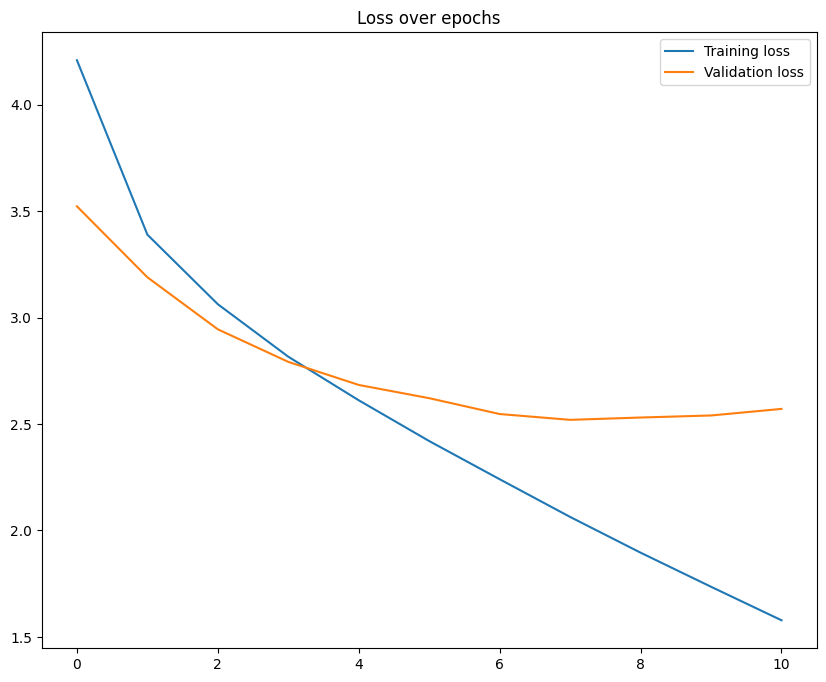

In [39]:
artifacts_path = f'{drive_model_location}/additive-attention-de-en-translator-basic-model-artifacts.json'
save_artifacts(basic_model, train_losses, val_losses, artifacts_path, model_path)
show_graph(train_losses, val_losses, save_path=f'{drive_model_location}/additive-attention-de-en-translator-basic-model-loss-graph.png', save=True)

In [167]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

In [168]:
load_model(basic_model, 'weights/additive-attention-de-en-translator-basic-model.pt')

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
    (encoder_hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (encoder_cell_projection): Linear(in_features=1024, out_features=512, bias=True)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

In [178]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

In [190]:
@torch.no_grad()
def translate(model, test_loader, criterion, device):
    model.eval()

    one_batch = next(iter(test_loader))
    one_batch = batch_to_device(one_batch, device)

    targets = one_batch["target"]
    logits_all, preds_all = model(one_batch["source"], one_batch["source_lengths"])

    for i in range(preds_all.shape[0]):
        print(f"Source: {decode(de_index_to_vocab, one_batch['source'][i].tolist())}")
        print(f"Pred: {decode(en_index_to_vocab, preds_all[i].tolist())}")
        print(f"Target: {decode(en_index_to_vocab, targets[i].tolist())}")
        print("-"*100)


In [191]:
translate(basic_model, test_loader, criterion, device)

Source: ein mann mit einem orangefarbenen hut , der etwas <unk> .
Pred: a man with a beard in his hat is working on a roof . .
Target: a man in an orange hat starring at something .
----------------------------------------------------------------------------------------------------
Source: ein boston terrier läuft über <unk> - grünes gras vor einem weißen zaun .
Pred: a brown dog is running through a field with a white dog that is coming out of the water .
Target: a boston terrier is running on lush green grass in front of a white fence .
----------------------------------------------------------------------------------------------------
Source: ein mädchen in einem karateanzug bricht ein brett mit einem tritt .
Pred: a girl in a pink outfit is riding a bicycle in a field .
Target: a girl in karate uniform breaking a stick with a front kick .
----------------------------------------------------------------------------------------------------
Source: fünf leute in winterjacken und mit h